In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import glob
from decimal import Decimal
from eofs.xarray import Eof

In [2]:
plt.style.use('ggplot')

In [3]:
reso = [0.01,0.02,0.025,0.03,0.04,0.05,0.1]
c = 10
deltaS = reso[1]
deltaT = c*deltaS
region = 'global'

In [4]:
# -- Read regular V 
V = xr.open_dataset('/data/ysilvy/bin_TS/volumeTS_global_'+str(deltaS)+'_'+str(deltaT)+'_IPSL-CM5A-LR_historical-rcp85_r2i1p1_1850-2100.nc')
V = V.histogram_so_thetao
# -- Small window in TS space
Vwindow = V.sel(so_bin=slice(33.5,36),thetao_bin=slice(10,18))

In [5]:
# -- Read Vsmooth computed on a small window
V_smooth = xr.open_dataset('/data/ysilvy/bin_TS/volumeTS_smoothdopt_window_'+region+'_'+str(deltaS)+'_'+str(deltaT)+'_IPSL-CM5A-LR_historical-rcp85_r2i1p1_1850-2100.nc')
Vsmooth1 = V_smooth.Vsmooth_fourthdopt 
Vsmooth2 = V_smooth.Vsmooth_halfdopt # smoothing applied with doptimal/2
# smoothing applied with doptimal/4
# Vsmooth1 = xr.open_dataset('/data/ysilvy/bin_TS/volumeTS_smoothdopt4_'+region+'_'+str(deltaS)+'_'+str(deltaT)+'_IPSL-CM5A-LR_historical-rcp85_r2i1p1_1850-2100.nc').Vsmooth_dopt_div_4

## Rapide coup d'oeil aux 3 champs avant de faire les EOF 
### V, Vsmooth_dopt, Vsmooth_dopt/2 en 1850, 2100 et anomalie

/home/ysilvy/.conda/envs/cdat81_py36/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


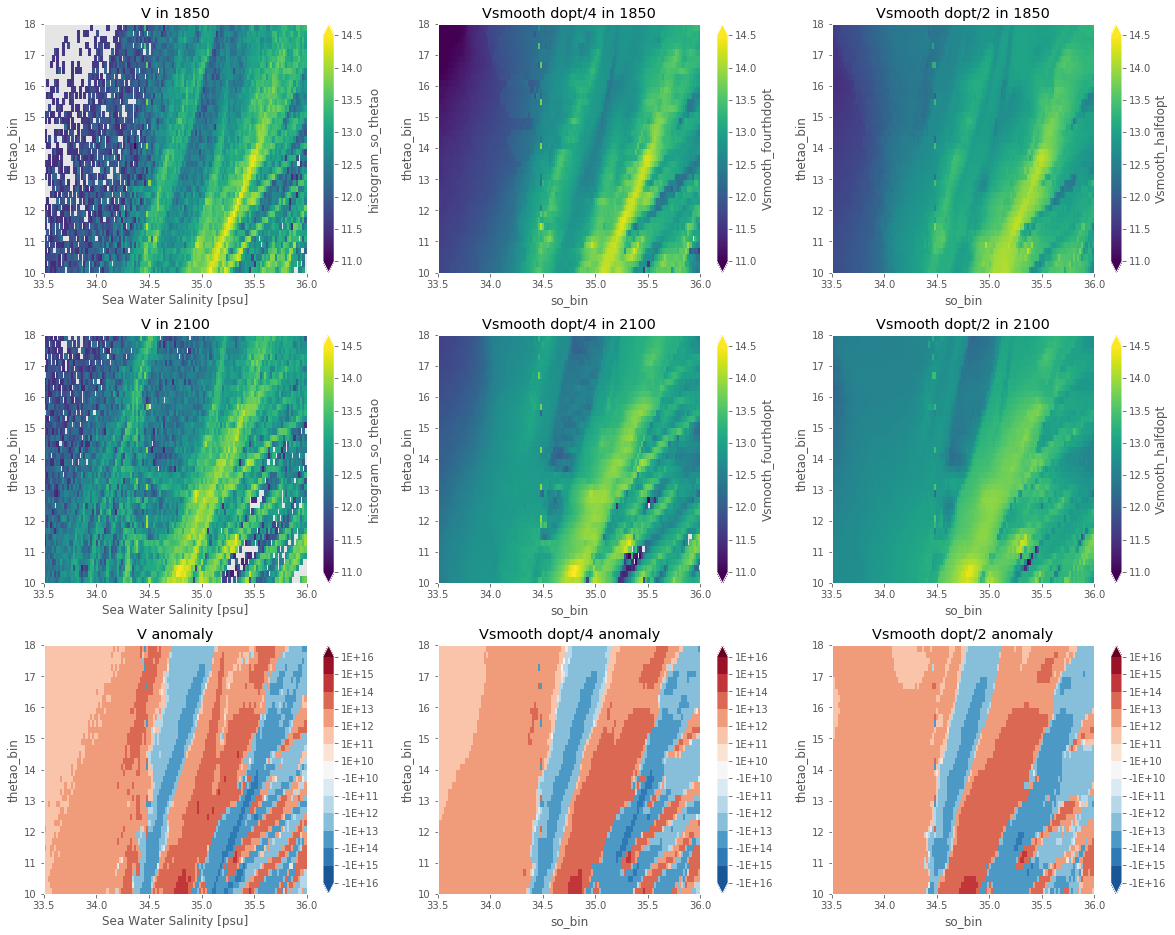

In [6]:
# -- Plot volumes in 1850, 2100 and anomaly
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(20,16))

# 1850
np.log10(Vwindow.T.isel(time=0)).plot(ax=ax[0,0],extend='both',vmin=11,vmax=14.5)
ax[0,0].set_title('V in 1850')
np.log10(Vsmooth1.T.isel(time=0)).plot(ax=ax[0,1],extend='both',vmin=11,vmax=14.5)
ax[0,1].set_title('Vsmooth dopt/4 in 1850')
np.log10(Vsmooth2.T.isel(time=0)).plot(ax=ax[0,2],extend='both',vmin=11,vmax=14.5)
ax[0,2].set_title('Vsmooth dopt/2 in 1850')

# 2100
np.log10(Vwindow.T.isel(time=-1)).plot(ax=ax[1,0],extend='both',vmin=11,vmax=14.5)
ax[1,0].set_title('V in 2100')
np.log10(Vsmooth1.T.isel(time=-1)).plot(ax=ax[1,1],extend='both',vmin=11,vmax=14.5)
ax[1,1].set_title('Vsmooth dopt/4 in 2100')
np.log10(Vsmooth2.T.isel(time=-1)).plot(ax=ax[1,2],extend='both',vmin=11,vmax=14.5)
ax[1,2].set_title('Vsmooth dopt/2 in 2100')

# Define anomaly = [2081-2100] - [1850-1899]
V_ano1 = Vsmooth1.isel(time=slice(-20,-1)).mean(dim='time')-Vsmooth1.isel(time=slice(0,50)).mean(dim='time')
V_ano2 = Vsmooth2.isel(time=slice(-20,-1)).mean(dim='time')-Vsmooth2.isel(time=slice(0,50)).mean(dim='time')
V_ano = Vwindow.isel(time=slice(-20,-1)).mean(dim='time')-Vwindow.isel(time=slice(0,50)).mean(dim='time')

levels = [-1.e16,-1.e15,-1.e14,-1.e13,-1.e12,-1.e11,-1.e10,1.e10,1.e11,1.e12,1.e13,1.e14,1.e15,1.e16]
levels_str = ['%.0E' % Decimal(str(w)) for w in levels]

# Anomaly
c=V_ano.T.plot(ax=ax[2,0],levels=levels,extend='both',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[2,0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[2,0].set_title('V anomaly')
c=V_ano1.T.plot(ax=ax[2,1],levels=levels,extend='both',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[2,1],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[2,1].set_title('Vsmooth dopt/4 anomaly')
c=V_ano2.T.plot(ax=ax[2,2],levels=levels,extend='both',add_colorbar=False)
cb = fig.colorbar(c,ax=ax[2,2],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[2,2].set_title('Vsmooth dopt/2 anomaly');

plt.subplots_adjust(hspace=0.25)

## EOF centrées réduites 

In [7]:
def compute_eof(V):
    # -- Center and reduce data prior to performing EOF
    Vred = V - V.mean(dim='time')
    Vred = Vred/V.std(dim='time')
    
    # -- Perform EOF
    solver=Eof(Vred.stack(z=('so_bin', 'thetao_bin')))
    pcs = solver.pcs(npcs=3)
    eofs = solver.eofs(neofs=3)
    variance_frac = solver.varianceFraction()
    
    return Vred, solver, pcs, eofs, variance_frac

In [8]:
Vred, solver, pcs, eofs, variance_frac = compute_eof(Vwindow)
Vred1, solver1, pcs1, eofs1, variance_frac1 = compute_eof(Vsmooth1)
Vred2, solver2, pcs2, eofs2, variance_frac2 = compute_eof(Vsmooth2)

## Mode 1 

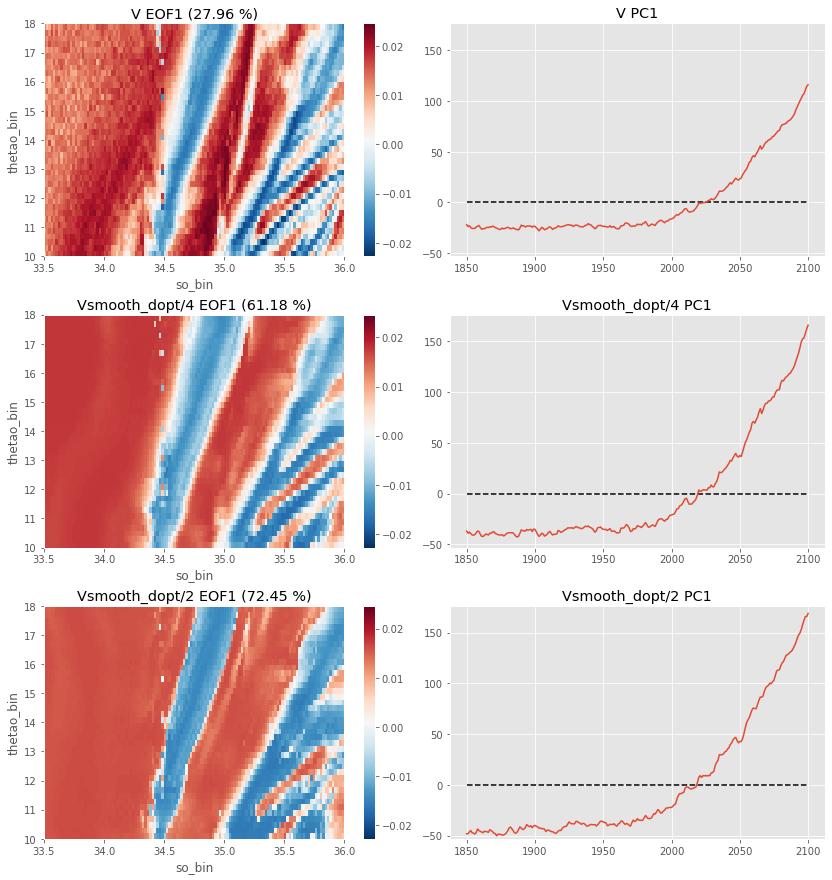

In [10]:
time=np.arange(1850,2101)

fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

var10 = variance_frac[0].data*100
var11 = variance_frac1[0].data*100
var12 = variance_frac2[0].data*100
eof10 = eofs[0,:].unstack('z')
eof11 = eofs1[0,:].unstack('z')
eof12 = eofs2[0,:].unstack('z')

vmin = np.min(np.array([eof10,eof11,eof12]))
vmax = np.max(np.array([eof10,eof11,eof12]))

c = eof10.T.plot(ax=ax[0,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('V EOF1 ('+'%.2f '% Decimal(str(var10))+'%)')
ax[0,1].plot(time,pcs[:,0])
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('V PC1')
# ax[0,0].scatter(34.51,17.5,marker='x',color='black')

c = eof11.T.plot(ax=ax[1,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('Vsmooth_dopt/4 EOF1 ('+'%.2f '% Decimal(str(var11))+'%)')
ax[1,1].plot(time,pcs1[:,0])
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('Vsmooth_dopt/4 PC1')
# ax[1,0].scatter(34.51,17.5,marker='x',color='black')

c = eof12.T.plot(ax=ax[2,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('Vsmooth_dopt/2 EOF1 ('+'%.2f '% Decimal(str(var12))+'%)')
ax[2,1].plot(time,pcs2[:,0])
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('Vsmooth_dopt/2 PC1')
# ax[2,0].scatter(34.51,17.5,marker='x',color='black')

ylim = ax[1,1].get_ylim()
ax[0,1].set_ylim(ylim[0],ylim[1])
ax[2,1].set_ylim(ylim[0],ylim[1])

plt.subplots_adjust(hspace=0.25,wspace=0.08)
# title = ''
# plt.suptitle(title,fontsize=14,fontweight='bold')


## Mode 2 

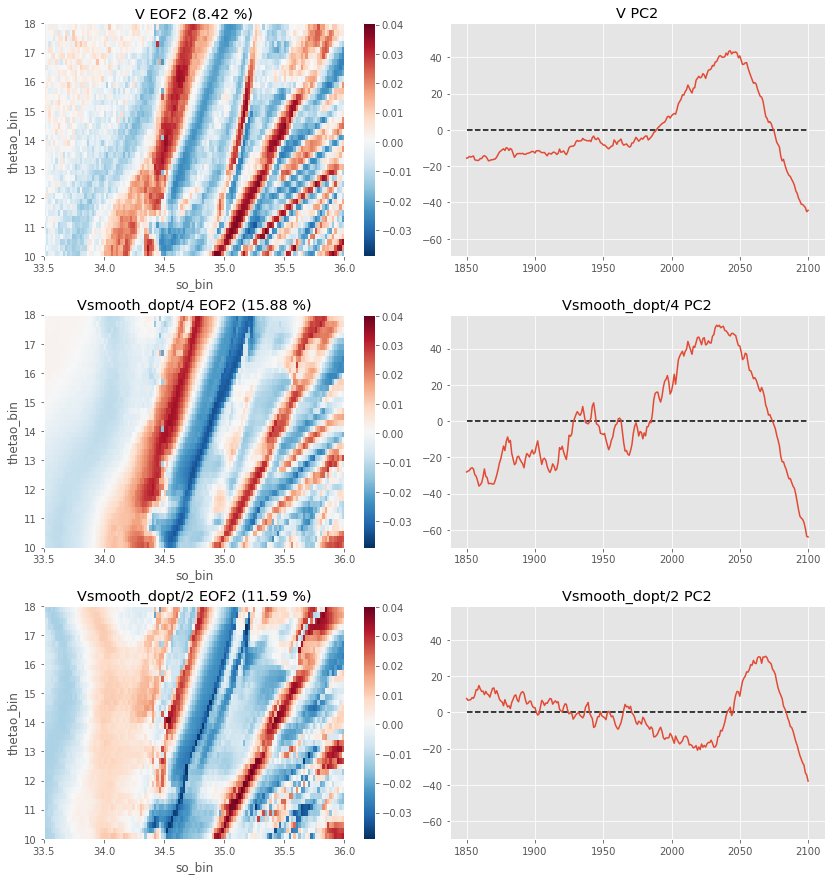

In [13]:
time=np.arange(1850,2101)

fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

var20 = variance_frac[1].data*100
var21 = variance_frac1[1].data*100
var22 = variance_frac2[1].data*100
eof20 = eofs[1,:].unstack('z')
eof21 = eofs1[1,:].unstack('z')
eof22 = eofs2[1,:].unstack('z')

vmin = np.min(np.array([eof20,eof21,eof22]))
vmax = np.max(np.array([eof20,eof21,eof22]))

c = eof20.T.plot(ax=ax[0,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('V EOF2 ('+'%.2f '% Decimal(str(var20))+'%)')
ax[0,1].plot(time,pcs[:,1])
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('V PC2')

c = eof21.T.plot(ax=ax[1,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('Vsmooth_dopt/4 EOF2 ('+'%.2f '% Decimal(str(var21))+'%)')
ax[1,1].plot(time,pcs1[:,1])
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('Vsmooth_dopt/4 PC2')

c = eof22.T.plot(ax=ax[2,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('Vsmooth_dopt/2 EOF2 ('+'%.2f '% Decimal(str(var22))+'%)')
ax[2,1].plot(time,pcs2[:,2])
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('Vsmooth_dopt/2 PC2')

ylim = ax[1,1].get_ylim()
ax[0,1].set_ylim(ylim[0],ylim[1])
ax[2,1].set_ylim(ylim[0],ylim[1])

plt.subplots_adjust(hspace=0.25,wspace=0.08)
# title = ''
# plt.suptitle(title,fontsize=14,fontweight='bold')


## Mode 3

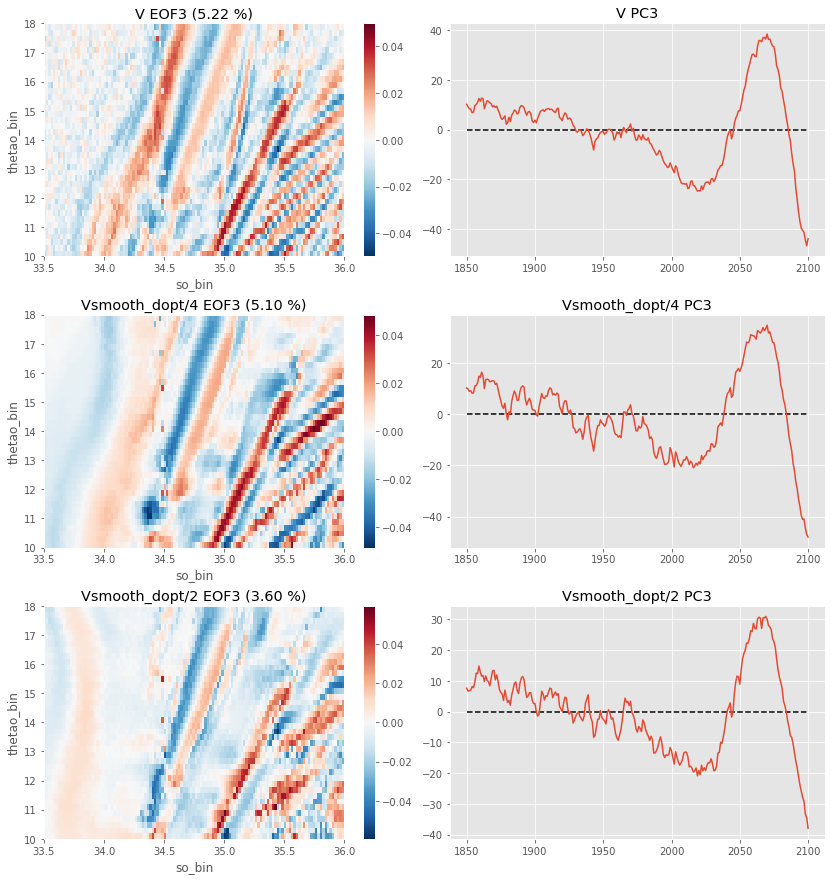

In [14]:
time=np.arange(1850,2101)

fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

var30 = variance_frac[2].data*100
var31 = variance_frac1[2].data*100
var32 = variance_frac2[2].data*100
eof30 = eofs[2,:].unstack('z')
eof31 = eofs1[2,:].unstack('z')
eof32 = eofs2[2,:].unstack('z')

c = eof30.T.plot(ax=ax[0,0],add_colorbar=False)
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('V EOF3 ('+'%.2f '% Decimal(str(var30))+'%)')
ax[0,1].plot(time,pcs[:,2])
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('V PC3')

c = eof31.T.plot(ax=ax[1,0],add_colorbar=False)
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('Vsmooth_dopt/4 EOF3 ('+'%.2f '% Decimal(str(var31))+'%)')
ax[1,1].plot(time,pcs1[:,2])
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('Vsmooth_dopt/4 PC3')

c = eof32.T.plot(ax=ax[2,0],add_colorbar=False)
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('Vsmooth_dopt/2 EOF3 ('+'%.2f '% Decimal(str(var32))+'%)')
ax[2,1].plot(time,pcs2[:,2])
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('Vsmooth_dopt/2 PC3')

plt.subplots_adjust(hspace=0.25,wspace=0.08)

## Variance

(0, 0.05)

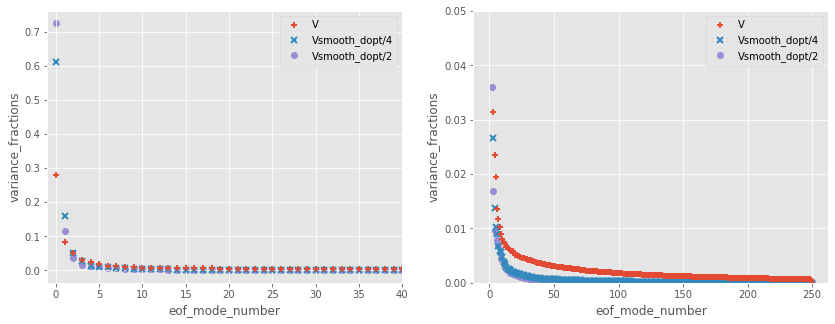

In [15]:
fig,ax=plt.subplots(ncols=2,figsize=(14,5))
for i in range(2):
    variance_frac.plot(ax=ax[i],marker='+',mew=2,linewidth=0,label='V',zorder=2)
    variance_frac1.plot(ax=ax[i],marker='x',mew=2,linewidth=0,label='Vsmooth_dopt/4',zorder=1)
    variance_frac2.plot(ax=ax[i],marker='o',mew=1,linewidth=0,label='Vsmooth_dopt/2',zorder=0)
    ax[i].legend();
ax[0].set_xlim([-1,40])
ax[1].set_ylim([0,0.05])
# ax[0].set_ylim([0,0.1])
# plt.suptitle('Resolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT))